Mount the google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the modules

In [2]:
!pip install attrdict

import logging
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import os.path as osp
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from attrdict import AttrDict
from collections import OrderedDict
from copy import deepcopy
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as tvds
from torch.distributions import StudentT, Normal, kl_divergence
from torch.utils.data import DataLoader


Datasets and helper functions
- Please change the path if needed in accordance with your actual HW4 directory location in Google drive
- Please implement the CelebA dataset module that reads and processes train.pt and eval.pt files
- Please assign proper values or variables for `num_ctx` and `num_tar` in `image_to_task` function.

In [3]:
#### PLEASE CHANGE THE PATH IF NEEDED ####
evalsets_path = osp.join('/content', 'drive', 'MyDrive', 'HW4', 'evalsets')
datasets_path = osp.join('/content', 'drive', 'MyDrive', 'HW4', 'datasets')
results_path = osp.join('/content', 'drive', 'MyDrive', 'HW4', 'results')


class EMNIST(tvds.EMNIST):
    def __init__(self, train=True, class_range=[0, 10],
                 device='cpu', download=True):
        super().__init__(datasets_path, train=train,
                         split='balanced', download=download)
        
        self.data = self.data.unsqueeze(1).float().div(255).transpose(-1, -2).to(device)
        self.targets = self.targets.to(device)

        idxs = []
        for c in range(class_range[0], class_range[1]):
            idxs.append(torch.where(self.targets==c)[0])
        idxs = torch.cat(idxs)

        self.data = self.data[idxs]
        self.targets = self.targets[idxs]

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]


class CelebA(object):
    #### TODO: WRITE YOUR DATASET MODULE FOR CELEBA ####
    # HINT: USE attached train.pt, eval.pt 
    # for train dataset and eval dataset, respectively
    def __init__(self, train=True):
        self.dataset.to(device)
        if train:
            self.dataset.load_state_dict(torch.load(datasets_path + '/celeba/train.pt'))
        else:
            self.dataset.load_state_dict(torch.load(datasets_path + '/celeba/eval.pt'))
    def __len__(self):
        return len(self.dataset)        
    def __getitem__(self, index):
        return self.dataset[index]
    ####################################################


def img_to_task(img, num_ctx=None, max_num_points=None, target_all=False, 
                t_noise=None, device=None):

    B, C, H, W = img.shape
    num_pixels = H * W
    img = img.view(B, C, -1)

    if t_noise is not None:
        if t_noise == -1:
            t_noise = 0.09 * torch.rand(img.shape)
        img += t_noise * StudentT(2.1).rsample(img.shape)

    device = img.device if device is None else device

    batch = AttrDict()
    max_num_points = max_num_points or num_pixels
    #### TODO: CHANGE NONE APPROPRIATELY ####
    num_ctx = np.random.randint(3,max_num_points)
    num_tar = np.random.randint(0,max_num_points)
    print("Num_ctx: ",num_ctx)
    print("Num_tar: ", num_tar)
    #########################################
    num_points = num_ctx + num_tar
    idxs = torch.rand(B, num_pixels).argsort(-1)[..., :num_points].to(img.device)
    x1, x2 = idxs // W, idxs % W
    batch.x = torch.stack([
        2 * x1.float() / (H-1) - 1,
        2 * x2.float() / (W-1) - 1], -1).to(device)
    batch.y = (torch.gather(img, -1, idxs.unsqueeze(-2).repeat(1, C, 1))\
            .transpose(-2, -1) - 0.5).to(device)

    batch.xc = batch.x[:,:num_ctx]
    batch.xt = batch.x[:,num_ctx:]
    batch.yc = batch.y[:,:num_ctx]
    batch.yt = batch.y[:,num_ctx:]

    return batch


def task_to_img_emnist(xc, yc, xt, yt, shape):
    xc = xc.cpu()
    yc = yc.cpu()
    xt = xt.cpu()
    yt = yt.cpu()


    B = xc.shape[0]
    C, H, W = shape

    xc1, xc2 = xc[...,0], xc[...,1]
    xc1 = ((xc1+1)*(H-1)/2).round().long()
    xc2 = ((xc2+1)*(W-1)/2).round().long()

    xt1, xt2 = xt[...,0], xt[...,1]
    xt1 = ((xt1+1)*(H-1)/2).round().long()
    xt2 = ((xt2+1)*(W-1)/2).round().long()

    task_img = torch.zeros(B, 3, H, W).to(xc.device)
    task_img[:,2,:,:] = 1.0
    task_img[:,1,:,:] = 0.4

    for b in range(B):
        for c in range(C):
            if yc.size()[-1] == 1:
                task_img[b, c, xc1[b], xc2[b]] = yc.repeat(1, 1, 3)[b, :, min(c, C - 1)] + 0.5
            else:
                task_img[b, c, xc1[b], xc2[b]] = yc[b, :, min(c, C - 1)] + 0.5
    task_img = task_img.clamp(0, 1)

    completed_img = task_img.clone()
    for b in range(B):
        for c in range(C):
            if yt.size()[-1] == 1:
                completed_img[b, c, xt1[b], xt2[b]] = yt.repeat(1, 1, 3)[b, :, min(c, C - 1)] + 0.5
            else:
                completed_img[b, c, xt1[b], xt2[b]] = yt[b, :, min(c, C - 1)] + 0.5
    completed_img = completed_img.clamp(0, 1)

    return task_img, completed_img


def task_to_img_celeba(xc, yc, xt, yt, shape):
    xc = xc.cpu()
    yc = yc.cpu()
    xt = xt.cpu()
    yt = yt.cpu()

    B = xc.shape[0]
    C, H, W = shape

    xc1, xc2 = xc[...,0], xc[...,1]
    xc1 = ((xc1+1)*(H-1)/2).round().long()
    xc2 = ((xc2+1)*(W-1)/2).round().long()

    xt1, xt2 = xt[...,0], xt[...,1]
    xt1 = ((xt1+1)*(H-1)/2).round().long()
    xt2 = ((xt2+1)*(W-1)/2).round().long()

    task_img = torch.zeros(B, 3, H, W).to(xc.device)
    task_img[:,2,:,:] = 1.0
    task_img[:,1,:,:] = 0.4
    for b in range(B):
        for c in range(3):
            task_img[b,c,xc1[b],xc2[b]] = yc[b,:,min(c,C-1)] + 0.5
    task_img = task_img.clamp(0, 1)

    completed_img = task_img.clone()
    for b in range(B):
        for c in range(3):
            completed_img[b,c,xt1[b],xt2[b]] = yt[b,:,min(c,C-1)] + 0.5
    completed_img = completed_img.clamp(0, 1)

    return task_img, completed_img


def img_to_task_original(img, num_ctx=None,
                         max_num_points=None, device=None, t_noise=None):

    B, C, H, W = img.shape
    num_pixels = H * W
    img = img.view(B, C, -1)  # [B,C,H*W]

    if t_noise is not None:
        if t_noise == -1:
            torch.manual_seed(0)
            t_noise = 0.09 * torch.rand(img.shape)
        img += t_noise * StudentT(2.1).rsample(img.shape)

    device = img.device if device is None else device

    batch = AttrDict()
    max_num_points = max_num_points or num_pixels
    num_ctx = num_ctx
    num_tar = max_num_points - num_ctx
    num_points = num_ctx + num_tar
    idxs = torch.tensor(
        [list(range(num_pixels)) for _ in range(B)], device=img.device
    )
    x1, x2 = idxs // W, idxs % W
    batch.x = torch.stack([
        2 * x1.float() / (H - 1) - 1,
        2 * x2.float() / (W - 1) - 1], -1).to(device)
    batch.y = (torch.gather(img, -1, idxs.unsqueeze(-2).repeat(1, C, 1))\
            .transpose(-2, -1) - 0.5).to(device)

    batch.xc = batch.x[:,:num_ctx]
    batch.xt = batch.x[:,num_ctx:]
    batch.yc = batch.y[:,:num_ctx]
    batch.yt = batch.y[:,num_ctx:]

    return batch

Attention modules

In [4]:
class MultiHeadAttn(nn.Module):
    def __init__(self, dim_q, dim_k, dim_v, dim_out, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.dim_out = dim_out
        self.fc_q = nn.Linear(dim_q, dim_out, bias=False)
        self.fc_k = nn.Linear(dim_k, dim_out, bias=False)
        self.fc_v = nn.Linear(dim_v, dim_out, bias=False)
        self.fc_out = nn.Linear(dim_out, dim_out)
        self.ln1 = nn.LayerNorm(dim_out)
        self.ln2 = nn.LayerNorm(dim_out)

    def scatter(self, x):
        return torch.cat(x.chunk(self.num_heads, -1), -3)

    def gather(self, x):
        return torch.cat(x.chunk(self.num_heads, -3), -1)

    def attend(self, q, k, v, mask=None):
        q_, k_, v_ = [self.scatter(x) for x in [q, k, v]]
        A_logits = q_ @ k_.transpose(-2, -1) / math.sqrt(self.dim_out)
        A = torch.softmax(A_logits, -1)
        return self.gather(A @ v_)

    def forward(self, q, k, v, mask=None):
        q, k, v = self.fc_q(q), self.fc_k(k), self.fc_v(v)
        out = self.ln1(q + self.attend(q, k, v, mask=mask))
        out = self.ln2(out + F.relu(self.fc_out(out)))
        return out


class SelfAttn(MultiHeadAttn):
    def __init__(self, dim_in, dim_out, num_heads=8):
        super().__init__(dim_in, dim_in, dim_in, dim_out, num_heads)

    def forward(self, x, mask=None):
        return super().forward(x, x, x, mask=mask)

Encoder and decoder


*   `PoolingEncoder` takes context points as input and outputs a single representation of them. There are cases where `self-attention` is used to calculate representations for each context point and cases where it is not. And if it is used as a latent path (`self.use_lat=True`), it returns the distribution (Normal) of the latent variable, not the deterministic representation.
*   `CrossAttnEncoder` performs the same role as `PoolingEncoder`, but takes target points as additional input and utilizes `multi-head attention` instead of `mean` to aggregate representations.
*   `Decoder` receives the target points and representation calculated from the `Encoder` as inputs and returns a predictive distribution for the given function.





In [5]:
def build_mlp(dim_in, dim_hid, dim_out, depth):
    modules = [nn.Linear(dim_in, dim_hid), nn.ReLU(True)]
    for _ in range(depth - 2):
        modules.append(nn.Linear(dim_hid, dim_hid))
        modules.append(nn.ReLU(True))
    modules.append(nn.Linear(dim_hid, dim_out))
    return nn.Sequential(*modules)


class PoolingEncoder(nn.Module):
    def __init__(self, dim_x=1, dim_y=1,
                 dim_hid=128, dim_lat=None, self_attn=False,
                 pre_depth=4, post_depth=2):
        super().__init__()

        self.use_lat = dim_lat is not None

        if not self_attn:
            self.net_pre = build_mlp(dim_x + dim_y, dim_hid, dim_hid, pre_depth)
        else:
            self.net_pre = nn.Sequential(
                build_mlp(dim_x + dim_y, dim_hid, dim_hid, pre_depth - 2),
                nn.ReLU(True),
                SelfAttn(dim_hid, dim_hid))

        self.net_post = build_mlp(dim_hid, dim_hid, 
                                  2 * dim_lat if self.use_lat else dim_hid,
                                  post_depth)

    def forward(self, xc, yc, mask=None):
        out = self.net_pre(torch.cat([xc, yc], -1))
        out = out.mean(-2)

        if self.use_lat:
            mu, sigma = self.net_post(out).chunk(2, -1)
            sigma = 0.1 + 0.9 * torch.sigmoid(sigma)
            return Normal(mu, sigma)
        else:
            return self.net_post(out)


class CrossAttnEncoder(nn.Module):
    def __init__(self, dim_x=1, dim_y=1, dim_hid=128,
                 dim_lat=None, self_attn=True,
                 v_depth=4, qk_depth=2):
        super().__init__()
        self.use_lat = dim_lat is not None

        if not self_attn:
            self.net_v = build_mlp(dim_x + dim_y, dim_hid, dim_hid, v_depth)
        else:
            self.net_v = build_mlp(dim_x + dim_y, dim_hid, dim_hid, v_depth - 2)
            self.self_attn = SelfAttn(dim_hid, dim_hid)

        self.net_qk = build_mlp(dim_x, dim_hid, dim_hid, qk_depth)

        self.attn = MultiHeadAttn(dim_hid, dim_hid, dim_hid,
                                  2 * dim_lat if self.use_lat else dim_hid)

    def forward(self, xc, yc, xt, mask=None):
        q, k = self.net_qk(xt), self.net_qk(xc)
        v = self.net_v(torch.cat([xc, yc], -1))

        if hasattr(self, 'self_attn'):
            v = self.self_attn(v, mask=mask)

        out = self.attn(q, k, v, mask=mask)
        if self.use_lat:
            mu, sigma = out.chunk(2, -1)
            sigma = 0.1 + 0.9 * torch.sigmoid(sigma)
            return Normal(mu, sigma)
        else:
            return out


class Decoder(nn.Module):
    def __init__(self, dim_x=1, dim_y=1,
                 dim_enc=128, dim_hid=128, depth=3):
        super().__init__()
        self.fc = nn.Linear(dim_x + dim_enc, dim_hid)
        self.dim_hid = dim_hid

        modules = [nn.ReLU(True)]
        for _ in range(depth - 2):
            modules.append(nn.Linear(dim_hid, dim_hid))
            modules.append(nn.ReLU(True))
        modules.append(nn.Linear(dim_hid, 2 * dim_y))
        self.mlp = nn.Sequential(*modules)

    def add_ctx(self, dim_ctx):
        self.dim_ctx = dim_ctx
        self.fc_ctx = nn.Linear(dim_ctx, self.dim_hid, bias=False)

    def forward(self, encoded, x, ctx=None):
        packed = torch.cat([encoded, x], -1)
        hid = self.fc(packed)

        if ctx is not None:
            hid = hid + self.fc_ctx(ctx)

        out = self.mlp(hid)
        mu, sigma = out.chunk(2, -1)
        sigma = 0.1 + 0.9 * F.softplus(sigma)
        return Normal(mu, sigma)

Neural Process modules: NP and ANP
- Please assign `denc`, `lenc`, `dec` members in `NP` and `ANP` class with proper modules <br> (hint: use `PoolingEncoder`, `CrossAttnEncoder` and `Decoder`)

In [6]:
def logmeanexp(x, dim=0):
    return x.logsumexp(dim) - math.log(x.shape[dim])


def stack(x, num_samples=None, dim=0):
    return x if num_samples is None \
             else torch.stack([x] * num_samples, dim=dim)


class NP(nn.Module):
    def __init__(self, dim_x=1, dim_y=1, dim_hid=128, dim_lat=128,
                 enc_pre_depth=4, enc_post_depth=2, dec_depth=3):

        super().__init__()
        #### TODO: CHANGE NONE TO APPROPRIATE MODULES ####
        # Implement deterministic path encoder
        self.denc = PoolingEncoder(dim_x=dim_x,
                                   dim_y=dim_y,
                                   dim_hid=dim_hid,
                                   dim_lat=dim_lat,
                                   self_attn=False,
                                   pre_depth=enc_pre_depth,
                                   post_depth=enc_post_depth,

                                   )
        # Implement latent path encoder
        self.lenc = CrossAttnEncoder(dim_x=dim_x,
                                     dim_y=dim_y,
                                     dim_hid=dim_hid,
                                     dim_lat=dim_lat
                                     )
        # Implement decoder
        self.dec = Decoder(dim_x=dim_x,
                           dim_y=dim_y,
                           dim_enc=dim_lat,
                           dim_hid=dim_hid
                           )
        
        ##################################################

    def predict(self, xc, yc, xt, z=None, num_samples=None):
        theta = stack(self.denc(xc, yc), num_samples)
        if z is None:
            pz = self.lenc(xc, yc)
            z = pz.rsample() if num_samples is None \
                    else pz.rsample([num_samples])
        encoded = torch.cat([theta, z], -1)
        encoded = stack(encoded, xt.shape[-2], -2)
        return self.dec(encoded, stack(xt, num_samples))

    def forward(self, batch, num_samples=None, reduce_ll=True):
        outs = AttrDict()
        if self.training:
            pz = self.lenc(batch.xc, batch.yc)
            qz = self.lenc(batch.x, batch.y)
            z = qz.rsample() if num_samples is None else \
                    qz.rsample([num_samples])
            py = self.predict(batch.xc, batch.yc, batch.x,
                    z=z, num_samples=num_samples)

            if num_samples > 1:
                # K * B * N
                recon = py.log_prob(stack(batch.y, num_samples)).sum(-1)
                # K * B
                log_qz = qz.log_prob(z).sum(-1)
                log_pz = pz.log_prob(z).sum(-1)

                # K * B
                log_w = recon.sum(-1) + log_pz - log_qz

                outs.loss = -logmeanexp(log_w).mean() / batch.x.shape[-2]
            else:
                outs.recon = py.log_prob(batch.y).sum(-1).mean()
                outs.kld = kl_divergence(qz, pz).sum(-1).mean()
                outs.loss = -outs.recon + outs.kld / batch.x.shape[-2]

        else:
            py = self.predict(xc=batch.xc, yc=batch.yc, xt=batch.x, z=None, num_samples=num_samples)
            if num_samples is None:
                ll = py.log_prob(batch.y).sum(-1)
            else:
                y = torch.stack([batch.y]*num_samples)
                if reduce_ll:
                    ll = logmeanexp(py.log_prob(y).sum(-1))
                else:
                    ll = py.log_prob(y).sum(-1)
            num_ctx = batch.xc.shape[-2]
            if reduce_ll:
                outs.ctx_ll = ll[...,:num_ctx].mean()
                outs.tar_ll = ll[...,num_ctx:].mean()
            else:
                outs.ctx_ll = ll[...,:num_ctx]
                outs.tar_ll = ll[...,num_ctx:]
        return outs


class ANP(nn.Module):
    def __init__(self, dim_x=1, dim_y=1, dim_hid=128, dim_lat=128,
                 enc_v_depth=4, enc_qk_depth=2, enc_pre_depth=4,
                 enc_post_depth=2, dec_depth=3):

        super().__init__()
        #### TODO: CHANGE NONE TO APPROPRIATE MODULES ####
        # Implement deterministic path encoder
        self.denc = PoolingEncoder(dim_x=dim_x,
                                   dim_y=dim_y,
                                   dim_hid=dim_hid,
                                   dim_lat=dim_lat,
                                   self_attn=False,
                                   pre_depth=enc_pre_depth,
                                   post_depth=enc_post_depth
                                   )
        # Implement latent path encoder
        self.lenc = CrossAttnEncoder(dim_x=dim_x,
                                     dim_y=dim_y,
                                     dim_hid=dim_hid,
                                     dim_lat=dim_lat,
                                     self_attn=True,
                                     v_depth=enc_v_depth,
                                     qk_depth=enc_qk_depth
                                     )
        # Implement decoder
        self.dec = Decoder(dim_x=dim_x,
                           dim_y=dim_y,
                           dim_enc=dim_lat,
                           dim_hid=dim_hid
                           )
        ##################################################

    def predict(self, xc, yc, xt, z=None, num_samples=None):
        theta = stack(self.denc(xc, yc, xt), num_samples)
        if z is None:
            pz = self.lenc(xc, yc)
            z = pz.rsample() if num_samples is None \
                             else pz.rsample([num_samples])
        z = stack(z, xt.shape[-2], -2)
        encoded = torch.cat([theta, z], -1)
        return self.dec(encoded, stack(xt, num_samples))

    def forward(self, batch, num_samples=None, reduce_ll=True):
        outs = AttrDict()
        if self.training:
            pz = self.lenc(batch.xc, batch.yc)
            qz = self.lenc(batch.x, batch.y)
            z = qz.rsample() if num_samples is None \
                             else qz.rsample([num_samples])
            py = self.predict(batch.xc, batch.yc, batch.x,
                              z=z, num_samples=num_samples)

            if num_samples > 1:
                # K * B * N
                recon = py.log_prob(stack(batch.y, num_samples)).sum(-1)
                # K * B
                log_qz = qz.log_prob(z).sum(-1)
                log_pz = pz.log_prob(z).sum(-1)

                # K * B
                log_w = recon.sum(-1) + log_pz - log_qz

                outs.loss = -logmeanexp(log_w).mean() / batch.x.shape[-2]
            else:
                outs.recon = py.log_prob(batch.y).sum(-1).mean()
                outs.kld = kl_divergence(qz, pz).sum(-1).mean()
                outs.loss = -outs.recon + outs.kld / batch.x.shape[-2]

        else:
            py = self.predict(batch.xc, batch.yc, batch.x,
                              num_samples=num_samples)
            if num_samples is None:
                ll = py.log_prob(batch.y).sum(-1)
            else:
                y = torch.stack([batch.y] * num_samples)
                if reduce_ll:
                    ll = logmeanexp(py.log_prob(y).sum(-1))
                else:
                    ll = py.log_prob(y).sum(-1)
            num_ctx = batch.xc.shape[-2]

            if reduce_ll:
                outs.ctx_ll = ll[...,:num_ctx].mean()
                outs.tar_ll = ll[...,num_ctx:].mean()
            else:
                outs.ctx_ll = ll[...,:num_ctx]
                outs.tar_ll = ll[...,num_ctx:]

        return outs

Hyperparameters and logger functions
- Please change the value of `task` and `model_name` if needed
- For training, `num_epochs` may not necessarily reach `200` in full 

In [7]:
max_num_points = 200
class_range = [0, 10]
#### CHANGE task AND model_name IF NEEDED ####
#### IN ACCORDANCE WITH YOUR TASK AND MODEL NAME #### 
task = 'emnist' # 'emnist' or 'celeba'
model_name = "anp"  # "np" or "anp"
#####################################################
train_batch_size = 100
train_num_samples = 4
lr = 5e-4
num_epochs = 200
eval_freq = 10
save_freq = 10
eval_batch_size = 16
eval_num_samples = 50
plot_batch_size = 16
plot_num_samples = 30
plot_num_ctx = 100


def get_logger(filename, mode='a'):
    logging.basicConfig(level=logging.INFO, format='%(message)s')
    logger = logging.getLogger()
    logger.addHandler(logging.FileHandler(filename, mode=mode))
    return logger


class RunningAverage(object):
    def __init__(self, *keys):
        self.sum = OrderedDict()
        self.cnt = OrderedDict()
        self.clock = time.time()
        for key in keys:
            self.sum[key] = 0
            self.cnt[key] = 0

    def update(self, key, val):
        if isinstance(val, torch.Tensor):
            val = val.item()
        if self.sum.get(key, None) is None:
            self.sum[key] = val
            self.cnt[key] = 1
        else:
            self.sum[key] = self.sum[key] + val
            self.cnt[key] += 1

    def reset(self):
        for key in self.sum.keys():
            self.sum[key] = 0
            self.cnt[key] = 0
        self.clock = time.time()

    def clear(self):
        self.sum = OrderedDict()
        self.cnt = OrderedDict()
        self.clock = time.time()

    def keys(self):
        return self.sum.keys()

    def get(self, key):
        assert(self.sum.get(key, None) is not None)
        return self.sum[key] / self.cnt[key]

    def info(self, show_et=True):
        line = ''
        for key in self.sum.keys():
            val = self.sum[key] / self.cnt[key]
            if type(val) == float:
                line += f'{key} {val:.4f} '
            else:
                line += f'{key} {val} '.format(key, val)
        if show_et:
            line += f'({time.time()-self.clock:.3f} secs)'
        return line

Model declarations
- Here it creates a neural process model for specified model (NP or ANP) and task (EMNIST or CelebA)


In [8]:
if model_name == "np":
    if task == 'emnist':
        model = NP(dim_x=2, dim_y=1, dim_hid=128, dim_lat=128,
                enc_pre_depth=5, enc_post_depth=3, dec_depth=4).cuda()
    elif task == 'celeba':
        model = NP(dim_x=2, dim_y=3, dim_hid=128, dim_lat=128,
                enc_pre_depth=6, enc_post_depth=3, dec_depth=5).cuda()
elif model_name == "anp":
    if task == 'emnist':
        model = ANP(dim_x=2, dim_y=1, dim_hid=128, dim_lat=128,
                    enc_v_depth=5, enc_qk_depth=3, enc_pre_depth=5,
                    enc_post_depth=3, dec_depth=4).cuda()
    elif task == 'celeba':
        model = ANP(dim_x=2, dim_y=3, dim_hid=128, dim_lat=128,
                    enc_v_depth=6, enc_qk_depth=3, enc_pre_depth=6,
                    enc_post_depth=3, dec_depth=5).cuda()
else:
    raise NotImplementedError



Datasets
- Here it creates the datasets for the specified task

In [9]:
if task == 'emnist':
    root = osp.join(results_path, "emnist", model_name)
    if not osp.exists(root):
        os.makedirs(root)
    train_ds = EMNIST(train=True, class_range=class_range)
    eval_ds = EMNIST(train=False, class_range=class_range)
elif task == 'celeba':
    root = osp.join(results_path, "celeba", model_name)
    if not osp.exists(root):
        os.makedirs(root)
    train_ds = CelebA(train=True)
    eval_ds = CelebA(train=False)

Training loop
- Here it trains the model with the training dataset

In [10]:
train_loader = DataLoader(train_ds, batch_size=train_batch_size,
                          shuffle=True, num_workers=2)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=len(train_loader) * num_epochs)

logfilename = osp.join(root, f"train_{time.strftime('%Y%m%d-%H%M')}.log")
start_epoch = 1
logger = get_logger(logfilename)
ravg = RunningAverage()
logger.info("Total number of parameters: {}\n".format(
            sum(p.numel() for p in model.parameters())))
for epoch in range(start_epoch, num_epochs + 1):
    model.train()
    for (x, _) in tqdm(train_loader):
        batch = img_to_task(x, max_num_points=max_num_points, device="cuda")
        optimizer.zero_grad()
        outs = model(batch, num_samples=train_num_samples)
        outs.loss.backward()
        optimizer.step()
        scheduler.step()

        for key, val in outs.items():
            ravg.update(key, val)

    line = f'{model_name}: epoch {epoch} '
    line += f'lr {optimizer.param_groups[0]["lr"]:.3e} '
    line += ravg.info()
    logger.info(line)

    ravg.reset()

    if epoch % save_freq == 0 or epoch == num_epochs:
        ckpt = AttrDict()
        ckpt.model = model.state_dict()
        ckpt.optimizer = optimizer.state_dict()
        ckpt.scheduler = scheduler.state_dict()
        ckpt.logfilename = logfilename
        ckpt.epoch = epoch + 1
        torch.save(ckpt, osp.join(root, "ckpt.tar"))

Total number of parameters: 464386



  0%|          | 0/240 [00:00<?, ?it/s]

Num_ctx:  149
Num_tar:  185


TypeError: ignored

Evaluation loop
 - Here it evaluates the model with the evaluation (validation) dataset

In [ ]:
# evaluation

def gen_evalset(task):
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)

    if task == 'emnist':
        eval_ds = EMNIST(train=False, class_range=class_range)
        eval_loader = torch.utils.data.DataLoader(eval_ds,
                                                batch_size=eval_batch_size,
                                                shuffle=False, num_workers=2)
        path = osp.join(evalsets_path, 'emnist')
        c1, c2 = class_range
        filename = f'{c1}-{c2}'
        filename += '.tar'
    elif task == 'celeba':
        eval_ds = CelebA(train=False)
        eval_loader = torch.utils.data.DataLoader(eval_ds,
                                                batch_size=eval_batch_size,
                                                shuffle=False, num_workers=2)
        path = osp.join(evalsets_path, 'celeba')
        filename = 'ckpt.tar'

    batches = []
    for x, _ in tqdm(eval_loader):
        batches.append(img_to_task(x, max_num_points=max_num_points))

    torch.manual_seed(time.time())
    torch.cuda.manual_seed(time.time())

    if not osp.isdir(path):
        os.makedirs(path)
        
    torch.save(batches, osp.join(path, filename))


ckpt = torch.load(osp.join(root, "ckpt.tar"))
model.load_state_dict(ckpt.model)
if task == 'emnist':
    c1, c2 = class_range
    eval_logfile = f'eval_{c1}-{c2}'
    eval_logfile += '.log'
    
    filename = osp.join(root, eval_logfile)
    logger = get_logger(filename, mode='w')
    
    path = osp.join(evalsets_path, 'emnist')
    c1, c2 = class_range
    filename = f'{c1}-{c2}'
    filename += '.tar'
elif task == 'celeba':
    eval_logfile = f'eval_ckpt.log'
    filename = osp.join(root, eval_logfile)
    logger = get_logger(filename, mode='w')
    path = osp.join(evalsets_path, 'celeba')
    filename = 'ckpt.tar'

if not osp.isfile(osp.join(path, filename)):
    print('generating evaluation sets...')
    gen_evalset(task=task)

eval_batches = torch.load(osp.join(path, filename))

torch.manual_seed(0)
torch.cuda.manual_seed(0)

ravg = RunningAverage()
model.eval()
with torch.no_grad():
    for batch in tqdm(eval_batches):
        for key, val in batch.items():
            batch[key] = val.cuda()
        outs = model(batch, num_samples=eval_num_samples)
        for key, val in outs.items():
            ravg.update(key, val)

torch.manual_seed(time.time())
torch.cuda.manual_seed(time.time())

c1, c2 = class_range
line = f'{model_name}: {c1}-{c2} '
line += ravg.info()

if logger is not None:
    logger.info(line)

  0%|          | 0/1248 [00:00<?, ?it/s]

np: 0-10 ctx_ll 2.9221 tar_ll 2.4014 (40.451 secs)


Plot module
- Test your trained model by plotting the image generated by your model

  0%|          | 0/1247 [00:00<?, ?it/s]

  0%|          | 0/1247 [00:00<?, ?it/s]

  0%|          | 0/1247 [00:00<?, ?it/s]

  0%|          | 0/1247 [00:00<?, ?it/s]

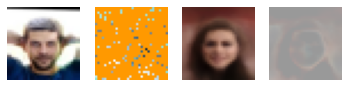

In [ ]:
# plot

seed = 0
device = torch.device("cuda")
model = model.to(device)
if task == 'emnist':
    c1, c2 = class_range
    plot_ds = EMNIST(train=False, class_range=class_range)
    plot_loader = DataLoader(plot_ds, batch_size=plot_batch_size,
                            shuffle=True, num_workers=2)
elif task == 'celeba':
    plot_ds = CelebA(train=False)
    plot_loader = DataLoader(plot_ds, batch_size=plot_batch_size, 
                            drop_last=True,
                            shuffle=True, num_workers=2)


ckpt = torch.load(osp.join(root, f'ckpt.tar'), map_location=device)
model.load_state_dict(ckpt.model)

if task == 'emnist':
    batches = []
    batches_original = []
    for x, _ in plot_loader:
        batches.append(img_to_task(x, num_ctx=plot_num_ctx,
                                    max_num_points=max_num_points))
        batches_original.append(img_to_task_original(x, num_ctx=x.shape[-1] * x.shape[-2],
                                                        max_num_points=x.shape[-1] * x.shape[-2]))
    
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)

    num_pixels = 28
    [B, C, H, W] = [plot_batch_size, 3, num_pixels, num_pixels]
    
    xt=[]
    for i in torch.linspace(-1, 1, num_pixels):
        for j in torch.linspace(-1, 1, num_pixels):
            xt.append(torch.cat([i.unsqueeze(0), j.unsqueeze(0)], dim=-1))
    xt = torch.stack(xt, 0).to(device)
    xt = torch.stack([xt] * B, dim=0)
    
    model.eval()
    print(f"Image Completion:   {model_name.upper()}")
    with torch.no_grad():
        for batch in batches:
            for key, val in batch.items():
                batch[key] = val.to(device)
    
        for batch in batches_original:
            for key, val in batch.items():
                batch[key] = val.to(device)
    
        # test with 10 outputs
        for i in range(10):
            batch = batches[i]
            # model prediction
            py = model.predict(batch.xc[i,:,:].unsqueeze(0),
                            batch.yc[i,:,:].unsqueeze(0),
                            xt[i,:,:].unsqueeze(0),
                            num_samples=plot_num_samples)
            mu, sigma = py.mean[i, :, :, :].squeeze(0), py.scale[i, :, :, :].squeeze(0)
    
            ctx_size = batch.yc.size(-2)
            context_img, mu_completed_img = task_to_img_emnist(batch.xc[i,:,:].unsqueeze(0),
                                                        batch.yc[i,:,:].unsqueeze(0),
                                                        xt[i,:,:].unsqueeze(0),
                                                        mu,
                                                        [C, H, W])
            _ , sigma_completed_img = task_to_img_emnist(batch.xc[i,:,:].unsqueeze(0),
                                                batch.yc[i,:,:].unsqueeze(0),
                                                xt[i,:,:].unsqueeze(0),
                                                sigma,
                                                [C, H, W])
            # original image
            batch = batches_original[i]
            py = model.predict(batch.xc[i,:,:].unsqueeze(0),
                            batch.yc[i,:,:].unsqueeze(0),
                            xt[i,:,:].unsqueeze(0),
                            num_samples=plot_num_samples)
            mu, sigma = py.mean[i, :, :, :].squeeze(0), py.scale[i, :, :, :].squeeze(0)
    
            original_img, _  = task_to_img_emnist(batch.xc[i,:,:].unsqueeze(0),
                                        batch.yc[i,:,:].unsqueeze(0),
                                        xt[i,:,:].unsqueeze(0),
                                        mu,
                                        [C, H, W])
    
            axes = []
            fig = plt.figure()
    
            axes.append(fig.add_subplot(1, 4, 1))
            plt.axis('off')
            plt.imshow(np.transpose(original_img[0], (1, 2, 0))[:,:,0], cmap='gray_r')
            axes.append(fig.add_subplot(1, 4, 2))
            plt.axis('off')
            plt.imshow(torch.ones((28,28,3))-np.transpose(context_img[0], (1, 2, 0)))
            axes.append(fig.add_subplot(1, 4, 3))
            plt.axis('off')
            plt.imshow(np.transpose(mu_completed_img[0], (1, 2, 0))[:,:,0], cmap='gray_r')
            axes.append(fig.add_subplot(1, 4, 4))
            plt.axis('off')
            plt.imshow(np.transpose(sigma_completed_img[0], (1, 2, 0))[:,:,0], cmap='Blues')
    
            plt.plot()

elif task == 'celeba':
    batches = []
    for x, _ in tqdm(plot_loader):
        batches.append(img_to_task(x, num_ctx=plot_num_ctx,
                                   max_num_points=max_num_points))

    torch.manual_seed(0)
    torch.cuda.manual_seed(0)

    num_pixels = 32
    [B, C, H, W] = [plot_batch_size, 3, num_pixels, num_pixels]

    xt=[]
    for i in torch.linspace(-1, 1, num_pixels):
        for j in torch.linspace(-1, 1, num_pixels):
            xt.append(torch.cat([i.unsqueeze(0), j.unsqueeze(0)], dim=-1))
    xt = torch.stack(xt, 0).to(device)
    xt = torch.stack([xt]*B, dim=0)

    model.eval()
    with torch.no_grad():
        for batch in tqdm(batches):
            for key, val in batch.items():
                batch[key] = val.to(device)
            # model prediction
            py = model.predict(batch.xc, batch.yc, xt,
                                num_samples=plot_num_samples)
            mu, sigma = py.mean[0, :, :, :], py.scale[0, :, :, :]

    ctx_size = batch.yc.size(-2)
    context_img, mu_completed_img = task_to_img_celeba(batch.xc[0,:,:].unsqueeze(0), batch.yc[0,:,:].unsqueeze(0), xt[0,:,:].unsqueeze(0), mu,[C, H, W])
    _ , sigma_completed_img = task_to_img_celeba(batch.xc[0,:,:].unsqueeze(0), batch.yc[0,:,:].unsqueeze(0), xt[0,:,:].unsqueeze(0), sigma, [C, H, W])

    # original image
    batches = []
    for x, _ in tqdm(plot_loader):
        batches.append(img_to_task_original(x, num_ctx=x.shape[-1] * x.shape[-2],
                                            max_num_points=x.shape[-1] * x.shape[-2],
                                            ))
    with torch.no_grad():
        for batch in tqdm(batches):
            for key, val in batch.items():
                batch[key] = val.cuda()
            py = model.predict(batch.xc[0,:,:].unsqueeze(0), batch.yc[0,:,:].unsqueeze(0), xt[0,:,:].unsqueeze(0),
                                num_samples=plot_num_samples)
            mu, sigma = py.mean[0, :, :, :], py.scale[0, :, :, :]

    original_img, _  = task_to_img_celeba(batch.xc[0,:,:].unsqueeze(0), batch.yc[0,:,:].unsqueeze(0), xt[0,:,:].unsqueeze(0), mu, [C, H, W])

    axes = []
    fig = plt.figure()

    axes.append(fig.add_subplot(1, 4, 1))
    plt.axis('off')
    plt.imshow(np.transpose(original_img[0], (1, 2, 0)))
    axes.append(fig.add_subplot(1, 4, 2))
    plt.axis('off')
    plt.imshow(torch.ones((num_pixels, num_pixels, 3))-np.transpose(context_img[0], (1, 2, 0)))
    axes.append(fig.add_subplot(1, 4, 3))
    plt.axis('off')
    plt.imshow(np.transpose(mu_completed_img[0], (1, 2, 0)))
    axes.append(fig.add_subplot(1, 4, 4))
    plt.axis('off')
    plt.imshow(np.transpose(sigma_completed_img[0], (1, 2, 0)))

    plt.plot()